# Consumer Complaints

- To find out which complaint is target to what department in organization

# 1)- Import key modules

In [1]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function
# I am an engineer. I care only about error not warning. So, let's be maverick and ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
# For processing and maths
import nltk
import sys
import re, numpy as np, pandas as pd

In [3]:
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
%matplotlib inline

In [4]:
# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

In [5]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

In [6]:
# first install: pip install version_information
%reload_ext version_information
%version_information pandas,numpy,nltk,gensim, matplotlib, seaborn

Software versions
Python 3.6.3 64bit [MSC v.1900 64 bit (AMD64)]
IPython 7.4.0
OS Windows 10 10.0.16299 SP0
pandas 0.23.4
numpy 1.16.2
nltk 3.2.4
gensim 3.7.1
matplotlib 2.1.0
seaborn 0.9.0
Mon Sep 30 17:56:21 2019 W. Europe Daylight Time

# 2)- Loading data

In [7]:
df=pd.read_csv('Consumer_Complaints.csv')
df.shape

(903983, 18)

In [8]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,3/12/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,3/17/2014,Closed with explanation,Yes,No,759217
1,10/1/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,352XX,NaN,Consent provided,Web,10/5/2016,Closed with explanation,Yes,No,2141773
2,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,NaN,"CITIZENS FINANCIAL GROUP, INC.",PA,177XX,Older American,Consent provided,Web,10/20/2016,Closed with explanation,Yes,No,2163100
3,6/8/2014,Credit card,NaN,Bankruptcy,NaN,NaN,NaN,AMERICAN EXPRESS COMPANY,ID,83854,Older American,NaN,Web,6/10/2014,Closed with explanation,Yes,Yes,885638
4,9/13/2014,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,NaN,"CITIBANK, N.A.",VA,23233,NaN,NaN,Web,9/13/2014,Closed with explanation,Yes,Yes,1027760


# 3)- Data Exploring

In [9]:
# Checking all variables with their data-type
def _tbl_dtype(dataset):
    sum_dtype = pd.DataFrame(dataset.dtypes).sort_values(0).rename(columns = {0:'Data Type'})
    return sum_dtype

table_dtype = _tbl_dtype(df)
table_dtype

,Data Type
Complaint ID,int64
Timely response?,object
Company response to consumer,object
Date sent to company,object
Submitted via,object
Consumer consent provided?,object
Tags,object
ZIP code,object
Date received,object
Company,object


In [10]:
df.Product.value_counts()

Mortgage                                                                        242194
Debt collection                                                                 171567
Credit reporting                                                                140424
Credit card                                                                      89190
Bank account or service                                                          86207
Credit reporting, credit repair services, or other personal consumer reports     59186
Student loan                                                                     38612
Consumer Loan                                                                    31608
Credit card or prepaid card                                                      11921
Checking or savings account                                                       9947
Payday loan                                                                       5546
Money transfers                            

### 3.1)- Checking missing values

In [11]:
def find_missing_values(df, columns):
    """
    Finds number of rows where certain columns are missing values.
    ::param_df:: = target dataframe
    ::param_columns:: = list of columns
    """
    missing_vals = {}
    print("Number of missing or NaN values for each column:")
    df_length = len(df)
    for column in columns:
        total_column_values = df[column].value_counts().sum()
        missing_vals[column] = df_length-total_column_values
        #missing_vals.append(str(column)+ " column has {} missing or NaN values.".format())
    return missing_vals

In [12]:
missing_values = find_missing_values(df, columns=df.columns)
missing_values

Number of missing or NaN values for each column:


{'Date received': 0,
 'Product': 0,
 'Sub-product': 235160,
 'Issue': 0,
 'Sub-issue': 477597,
 'Consumer complaint narrative': 704013,
 'Company public response': 646002,
 'Company': 0,
 'State': 9225,
 'ZIP code': 9278,
 'Tags': 777945,
 'Consumer consent provided?': 528549,
 'Submitted via': 0,
 'Date sent to company': 0,
 'Company response to consumer': 0,
 'Timely response?': 0,
 'Consumer disputed?': 135408,
 'Complaint ID': 0}

### 3.2)- Treating missing values

in our key feature i.e "Consumer complaint narrative"

In [13]:
df['Consumer complaint narrative'].dropna(how='all').shape

(199970,)

In [14]:
df['Consumer complaint narrative'].dropna(how='all', inplace=True)

We have created a new feature with zero missing values

In [15]:
df['Consumer complaint narrative'].isnull().sum()

0

In [16]:
complaint=df['Consumer complaint narrative']

# 4)- Data Cleaning

In [17]:
chars = list(set(complaint)) 
data_size, vocab_size = len(complaint), len(chars)
print ("Patent data has chars", data_size)
print ("Patent data has unique chars", vocab_size)

Patent data has chars 199970
Patent data has unique chars 195317


### 4.1)-Tokenize Sentences and Clean

In [18]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove extra characters
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)

In [19]:
# Convert to list
data = df['Consumer complaint narrative'].values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['have', 'outdated', 'information', 'on', 'my', 'credit', 'report', 'that', 'have', 'previously', 'disputed', 'that', 'has', 'yet', 'to', 'be', 'removed', 'this', 'information', 'is', 'more', 'then', 'seven', 'years', 'old', 'and', 'does', 'not', 'meet', 'credit', 'reporting', 'requirements']]


In [20]:
print(data_words[2])

['an', 'account', 'on', 'my', 'credit', 'report', 'has', 'mistaken', 'date', 'mailed', 'in', 'debt', 'validation', 'letter', 'to', 'allow', 'xxxx', 'to', 'correct', 'the', 'information', 'received', 'letter', 'in', 'the', 'mail', 'stating', 'that', 'experian', 'received', 'my', 'correspondence', 'and', 'found', 'it', 'to', 'be', 'suspicious', 'and', 'that', 'did', 'nt', 'write', 'it', 'experian', 'letter', 'is', 'worded', 'to', 'imply', 'that', 'am', 'incapable', 'of', 'writing', 'my', 'own', 'letter', 'was', 'deeply', 'offended', 'by', 'this', 'implication', 'called', 'experian', 'to', 'figure', 'out', 'why', 'my', 'letter', 'was', 'so', 'suspicious', 'spoke', 'to', 'representative', 'who', 'was', 'incredibly', 'unhelpful', 'she', 'did', 'not', 'effectively', 'answer', 'any', 'questions', 'asked', 'of', 'her', 'and', 'she', 'kept', 'ignoring', 'what', 'was', 'saying', 'regarding', 'the', 'offensive', 'letter', 'and', 'my', 'dispute', 'process', 'feel', 'the', 'representative', 'did', 

### 4.2)-Build the Bigram, Trigram Models,Postag and Lemmatize

In [21]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [22]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [23]:
df_data_ready = pd.DataFrame(data_ready)

In [24]:
df_data_ready.head()

,0,1,2,3,4,5,6,7,8,9,...,2522,2523,2524,2525,2526,2527,2528,2529,2530,2531
0,outdated,information,credit,report,previously,dispute,remove,information,year,old,...,None,None,None,None,None,None,None,None,None,None
1,purchase,new,car,xxxx,xxxx,car,dealer,call,citizen,bank,...,None,None,None,None,None,None,None,None,None,None
2,account,credit,report,mistaken,date,mail,debt,validation,letter,allow,...,None,None,None,None,None,None,None,None,None,None
3,company,refuse,provide,verification,validation,debt,believe,debt,mine,None,...,None,None,None,None,None,None,None,None,None,None
4,complaint,regard,square,financial,refer,cfpb,case,number,xxxx,regard,...,None,None,None,None,None,None,None,None,None,None


In [25]:
df_data_ready.shape

(199970, 2532)

In [26]:
import pickle
df_data_ready.to_pickle('data_ready.pkl')

# 5)- Build Topic Model

### 5.1)- Create Dictionary

In [27]:
#bag of words
id2word = corpora.Dictionary(data_ready)

In [28]:
print(len(id2word))

71260


In [29]:
count = 0
for k, v in id2word.iteritems():
    print(k, v, id2word.dfs[k])
    count += 1
    if count > 10:
        break

0 credit 102573
1 dispute 33627
2 information 54083
3 meet 4678
4 old 9727
5 outdated 257
6 previously 5703
7 remove 33245
8 report 74239
9 reporting 16626
10 requirement 4089


Filter out tokens that appear in

- less than 15 documents (absolute number) or
- more than 0.5 documents (fraction of total corpus size, not absolute number).
- after the above two steps, keep only the first 4000 most frequent tokens.

In [30]:
id2word.filter_extremes(no_below=15, no_above=0.5, keep_n=4000)

In [31]:
print(len(id2word))

4000


In [32]:
print (id2word[3])

old


id2word is a dictionary that contains words. All of our data word.

### 5.2)-Create Corpus: Term Document Frequency

In [33]:
corpus = [id2word.doc2bow(text) for text in data_ready]
corpus[500]

[(248, 1), (260, 1), (349, 1), (353, 2), (629, 1)]

In [34]:
print(len(corpus))

199970


In [35]:
bow_doc_500 = corpus[500]

for i in range(len(bow_doc_500)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_500[i][0], 
                                                     id2word[bow_doc_500[i][0]], 
                                                     bow_doc_500[i][1]))

Word 248 ("never") appears 1 time.
Word 260 ("show") appears 1 time.
Word 349 ("bill") appears 1 time.
Word 353 ("communication") appears 2 time.
Word 629 ("live") appears 1 time.


### 5.3)-Vectorization with TF-IDF
term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus

In [36]:
from gensim import corpora, models

tfidf = models.TfidfModel(corpus)

In [37]:
corpus_tfidf = tfidf[corpus]

In [38]:
from pprint import pprint

for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.16420850079409888),
 (1, 0.24088203510048548),
 (2, 0.3458820292915322),
 (3, 0.27845787548823264),
 (4, 0.6131296099909154),
 (5, 0.32763400900923817),
 (6, 0.16526079581269965),
 (7, 0.09126490685452844),
 (8, 0.2290838044383921),
 (9, 0.3582766353635814),
 (10, 0.13447800399414148)]


### 5.4)- Model Building

We shall apply LDA(Latent Dirichlet Allocation)

In [39]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus=corpus_tfidf, num_topics=10, id2word=id2word, passes=2, workers=2)

In [40]:
lda_model_tfidf.save('topic_model_tfidf')

In [41]:
from gensim.models import LdaModel
lda_model_tfidf = LdaModel.load('topic_model_tfidf')

In [42]:
#The trained topics (keywords and weights)
pprint(lda_model_tfidf.print_topics())

[(0,
  '0.022*"payment" + 0.015*"mortgage" + 0.014*"escrow" + 0.011*"late" + '
  '0.010*"insurance" + 0.009*"statement" + 0.008*"pay" + 0.008*"loan" + '
  '0.007*"fee" + 0.007*"month"'),
 (1,
  '0.038*"inquiry" + 0.021*"report" + 0.018*"equifax" + 0.012*"remove" + '
  '0.011*"address" + 0.011*"information" + 0.011*"name" + 0.010*"authorize" + '
  '0.010*"fraud" + 0.010*"identity_theft"'),
 (2,
  '0.012*"mortgage" + 0.011*"loan" + 0.010*"modification" + 0.009*"home" + '
  '0.006*"foreclosure" + 0.006*"sale" + 0.006*"property" + 0.005*"bank" + '
  '0.005*"fargo" + 0.005*"house"'),
 (3,
  '0.024*"loan" + 0.015*"navient" + 0.015*"payment" + 0.013*"student" + '
  '0.012*"interest" + 0.009*"pay" + 0.008*"rate" + 0.007*"school" + '
  '0.007*"month" + 0.006*"forbearance"'),
 (4,
  '0.034*"car" + 0.026*"vehicle" + 0.016*"lease" + 0.009*"ally" + '
  '0.009*"apartment" + 0.009*"santander" + 0.009*"dealership" + '
  '0.009*"finance" + 0.007*"auto" + 0.007*"pay"'),
 (5,
  '0.015*"card" + 0.012*"ban

# 6)-Evaluating model

### 6.1)- Compute Model Perplexity and Coherence Score
Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is

In [43]:
# Compute Perplexity:a measure of how good the model is. lower the better.
print('\nPerplexity: ', lda_model_tfidf.log_perplexity(corpus_tfidf)) 


Perplexity:  -7.83515763578667


In [44]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5155994670641701


### 6.2)-Analysis of LDA model

In [46]:
lda_model_tfidf.get_term_topics('mortgage')

[(0, 0.015184734), (2, 0.01156549)]

In [47]:
print(data_ready[0])

['outdated', 'information', 'credit', 'report', 'previously', 'dispute', 'remove', 'information', 'year', 'old', 'meet', 'credit', 'reporting', 'requirement']


In [48]:
doc_number = 0
doc_topic, word_topic, phi_value = lda_model_tfidf.get_document_topics(corpus_tfidf[doc_number], per_word_topics=True)

In [49]:
doc_topic

[(0, 0.025332663),
 (1, 0.025333755),
 (2, 0.025335273),
 (3, 0.025334725),
 (4, 0.025332578),
 (5, 0.025335638),
 (6, 0.7719846),
 (7, 0.025335485),
 (8, 0.025341053),
 (9, 0.025334233)]

The output gives the topic distribution of the document

In [50]:
word_topic

[(0, [6]),
 (1, [6]),
 (2, [6]),
 (3, [6]),
 (4, [6]),
 (5, [6]),
 (6, [6]),
 (7, [6]),
 (8, [6]),
 (9, [6]),
 (10, [6])]

Output gives you word belonging to topics in given documents. In our case, its 1st row

In [51]:
phi_value

[(0, [(6, 0.16420382)]),
 (1, [(6, 0.24087194)]),
 (2, [(6, 0.34569302)]),
 (3, [(6, 0.27831104)]),
 (4, [(6, 0.6129574)]),
 (5, [(6, 0.32760057)]),
 (6, [(6, 0.16525188)]),
 (7, [(6, 0.0912599)]),
 (8, [(6, 0.22907498)]),
 (9, [(6, 0.35815927)]),
 (10, [(6, 0.13440433)])]

The output gives a ranked list of topics for every word. The lower the rank, more is the probability of the word belonging to that topic in the document.
Phi values are essentially the probability of that word in that document belonging to a particular topic

# 7)- Results

In [52]:
import nltk; nltk.download('stopwords')
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\69785hsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [53]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

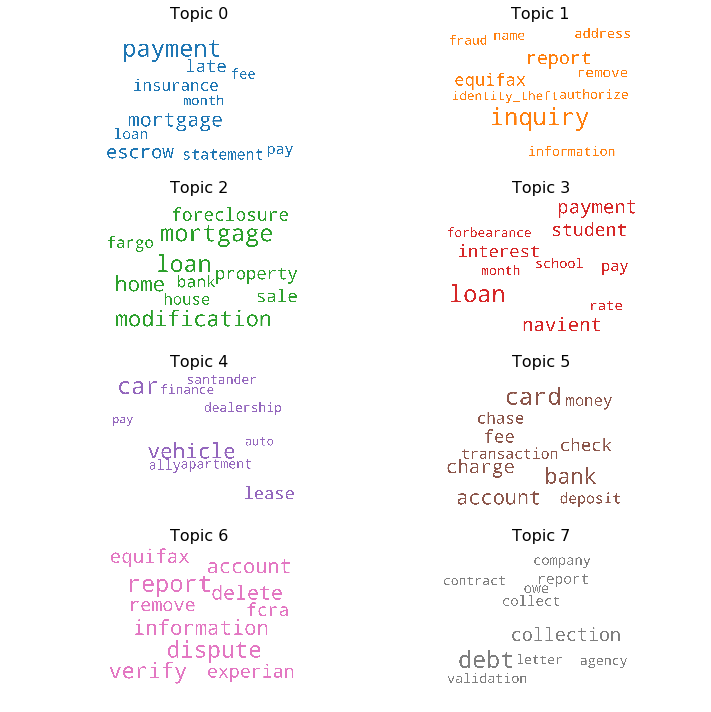

In [54]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model_tfidf.show_topics(formatted=False)

fig, axes = plt.subplots(4, 2, figsize=(10,10), sharex=True, sharey=True) # watch this value

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

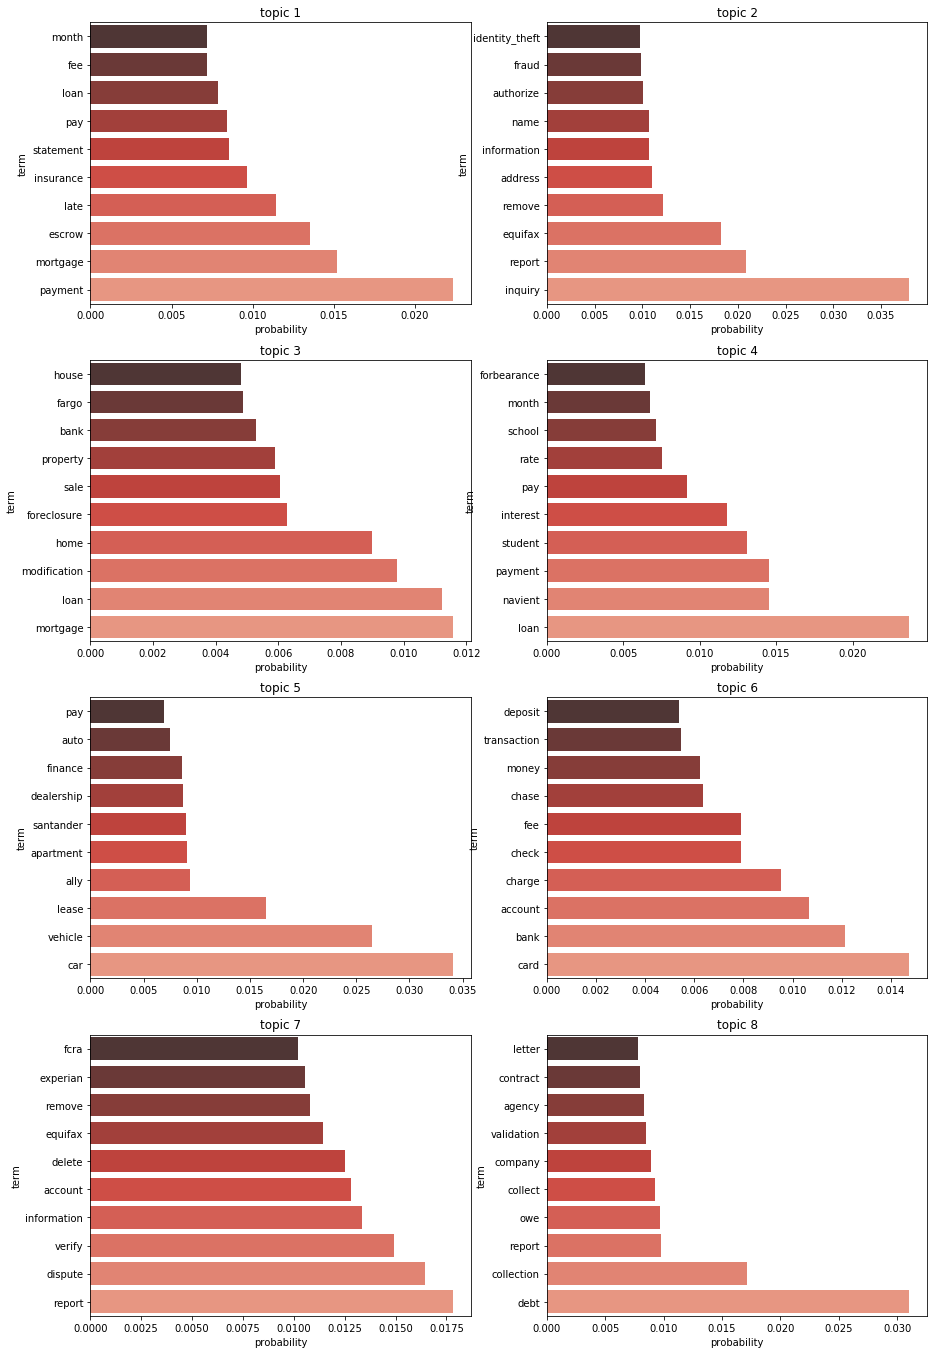

In [55]:
# bar plot
fiz=plt.figure(figsize=(15,30))
for i in range(8):
    df=pd.DataFrame(lda_model_tfidf.show_topic(i), columns=['term','prob']).set_index('term')
    df=df.sort_values('prob')
    
    plt.subplot(5,2,i+1)
    plt.title('topic '+str(i+1))
    sns.barplot(x='prob', y=df.index, data=df, label='patents', palette='Reds_d')
    plt.xlabel('probability')
    

plt.show()

In [57]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_tfidf, corpus_tfidf, dictionary=lda_model_tfidf.id2word)
vis

C:\Program Files\Anaconda3\lib\site-packages\numexpr\cpuinfo.py:109: DeprecationWarning: invalid escape sequence \d
  nbits = re.compile('(\d+)bit').search(abits).group(1)
C:\Program Files\Anaconda3\lib\site-packages\numexpr\cpuinfo.py:662: DeprecationWarning: invalid escape sequence \s
  "\s+stepping\s+(?P<STP>\d+)", re.IGNORECASE)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.057965  0.009178       1        1  18.963486
2      0.089645  0.045181       2        1  15.541413
9      0.036360 -0.085212       3        1  10.996967
7     -0.088631 -0.018108       4        1  10.168694
3      0.124565  0.053445       5        1   9.941730
0      0.085872  0.089048       6        1   8.110152
6     -0.200392  0.026574       7        1   7.972411
8     -0.092541  0.067598       8        1   7.669343
1     -0.147509 -0.068983       9        1   6.343570
4      0.134666 -0.118721      10        1   4.292233, topic_info=     Category         Freq            Term        Total  loglift  logprob
term                                                                     
438   Default  3053.000000         inquiry  3053.000000  30.0000  30.0000
7     Default  7181.000000          report  7181.000000  29.0000  29.0000
88    Default  6035.000000            debt  6035.000000  28.0000  28.0000
22    Default  1898.000000             car  1898.000000  27.0000  27.0000
272   Default  2851.000000         equifax  2851.000000  26.0000  26.0000
45    Default  6092.000000            loan  6092.000000  25.0000  25.0000
58    Default  6363.000000         payment  6363.000000  24.0000  24.0000
209   Default  3545.000000        mortgage  3545.000000  23.0000  23.0000
887   Default  1301.000000         vehicle  1301.000000  22.0000  22.0000
875   Default  1523.000000         navient  1523.000000  21.0000  21.0000
6     Default  3854.000000          remove  3854.000000  20.0000  20.0000
0     Default  3796.000000         dispute  3796.000000  19.0000  19.0000
351   Default  4068.000000      collection  4068.000000  18.0000  18.0000
763   Default  1271.000000          escrow  1271.000000  17.0000  17.0000
11    Default  6870.000000         account  6870.000000  16.0000  16.0000
21    Default  5389.000000            call  5389.000000  15.0000  15.0000
94    Default  1796.000000        experian  1796.000000  14.0000  14.0000
650   Default  1563.000000         student  1563.000000  13.0000  13.0000
490   Default  1679.000000    modification  1679.000000  12.0000  12.0000
1222  Default  1713.000000      transunion  1713.000000  11.0000  11.0000
317   Default  3174.000000            late  3174.000000  10.0000  10.0000
280   Default  2258.000000          verify  2258.000000   9.0000   9.0000
395   Default  1756.000000          delete  1756.000000   8.0000   8.0000
487   Default   847.000000           lease   847.000000   7.0000   7.0000
302   Default  4179.000000            card  4179.000000   6.0000   6.0000
1     Default  4318.000000     information  4318.000000   5.0000   5.0000
8     Default  2054.000000       reporting  2054.000000   4.0000   4.0000
944   Default  1875.000000      bankruptcy  1875.000000   3.0000   3.0000
161   Default  1226.000000  identity_theft  1226.000000   2.0000   2.0000
42    Default  2496.000000        interest  2496.000000   1.0000   1.0000
...       ...          ...             ...          ...      ...      ...
22    Topic10  1510.166748             car  1898.670166   2.9194  -3.3797
2729  Topic10    70.715630      automobile    78.848015   3.0395  -6.4410
2901  Topic10   152.904770             gap   185.556458   2.9548  -5.6698
460   Topic10   403.410889       apartment   552.615601   2.8337  -4.6997
3698  Topic10   105.696777        warranty   126.440498   2.9692  -6.0391
3176  Topic10   173.730301        accident   248.431732   2.7907  -5.5422
501   Topic10   300.968079            rent   531.789062   2.5791  -4.9927
1731  Topic10   119.673355      acceptance   168.744095   2.8047  -5.9149
1549  Topic10   112.223228        landlord   160.356735   2.7915  -5.9792
238   Topic10   380.106079         finance   900.343140   2.2860  -4.7592
660   Topic10   331.531494            auto   948.656555   2.0970  -4.8959
189   Topic10   270.234406           title   740.2457

In [58]:
pyLDAvis.save_html(vis, 'topics.html')